In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import nltk
from datetime import datetime
import numpy as np

In [2]:
# Reading the dataset

documents_amag = pd.read_csv(r"D:\Proyectos\amag\data_cleaned_test\intermediate\documents_amag_clean_2018.csv")
columns_to_drop = ['appeal', 'sentencia_acto', 'sentencia_sumilla', 'sentencia', 'auto_final',
                   'auto_definitivo', 'auto_improcedente', 'vista2', 'revoca2', 'nula2',
                   'confirma2', 'fundada', 'fundada_parte', 'infundada', 'vista', 'revoca',
                   'nula', 'confirma']

# Drop the specified columns
documents_amag.drop(columns=columns_to_drop, inplace=True)
documents_amag.rename(columns={'text': 'text_processed'}, inplace=True)

df_downloads = pd.read_csv(r"C:\Users\PC\Daniel Chen Dropbox\Alexis Malca\Peru_Justice\02_Data\08_CEJ_Web\data_cleaned\DF_DOWNLOADS_2018.csv")
documents_amag = documents_amag.merge(df_downloads[['file_path', 'text']], on='file_path', how='left')

# Getting how many casefiles we have

expediente_counts = documents_amag['expediente_n°_'].value_counts()
total_unique_files = expediente_counts.shape[0]
print("Total case files:", total_unique_files)

Total case files: 135147


In [3]:
# We must divide our dataset into two groups: finished by judgements and finished by orders.

judgements_df = documents_amag[documents_amag['acto_'].str.contains('sentencia', case=False, na=False)]

orders_df = pd.merge(documents_amag, judgements_df[['expediente_n°_']], on='expediente_n°_', how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)

In [ ]:
# Saving them on our paths for future working

judgements_df.to_csv(r'D:\Proyectos\amag\classification\sentencias_2018.csv')
orders_df.to_csv(r'D:\Proyectos\amag\classification\orders_2018.csv')

In [4]:
# Main functions 

def separate_case_files(main_df, second_df):

    # Perform the merge and filter the results
    output_df = pd.merge(main_df, 
                         second_df[['expediente_n°_']], 
                         on='expediente_n°_', 
                         how='left', 
                         indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
    
    return output_df

# Function that creates a new dataset with only the cases that are associated with at least one 'acto_' containing 'vista'

def filter_vista_cases(df):
    # Create a boolean Series where True indicates that 'acto_' contains 'vista'
    contains_keyword = df['acto_'].str.contains('vista', na=False)

    # Group by 'expediente_n°_' and check if any 'acto_' in each group contains 'vista'
    grouped = df.groupby('expediente_n°_').apply(lambda x: any(x['acto_'].str.contains('vista', na=False)))

    # Create a new DataFrame containing only the 'expediente_n°_' that are associated with at least one 'acto_' containing 'vista'
    output_df = df[df['expediente_n°_'].isin(grouped[grouped].index)]
    
    return output_df


# Function that creates a new dataset with only the cases that are associated with at least one 'acto_' containing a specific keyword 

def filter_keywords_cases(df, keywords):
    
    # Use str.contains with the regex pattern
    pattern = '|'.join(keywords)

    contains_keyword = df['acto_'].str.contains(pattern, na=False)
    
    # Group by 'expediente_n°_' and check if any 'acto_' in each group contains any of the keywords
    grouped = df.groupby('expediente_n°_').apply(lambda x: any(x['acto_'].str.contains(pattern, na=False)))
    
    # Create a new DataFrame containing only the 'expediente_n°_' that are associated with at least one 'acto_' containing keywords
    output_df = df[df['expediente_n°_'].isin(grouped[grouped].index)]
    
    return output_df

## 1. Approach with judgements

In this task, we only keep the rows that contains a word related to "Sentencia". 

Once we do this, we will take out from the merged_df the casefiles we found a "Sentencia" decision. 

The reason behind it, is that we want to keep only the cases that have been decided by the Court, and not the ones that could be still pending.

Then, we will run another code wit frequent expressions asocciated to final decisions to be sure that we are not missing any casefile with a final decision.

In [12]:
judgements_counts = judgements_df['acto_'].value_counts()
judgements_counts

sentencia                                                    36825
auto q declara consentida la sentencia                       13036
sentencia de vista                                            7995
sentencia fundada                                              875
sentencia fundada en parte                                     564
sentencia infundada                                            482
auto que declara consentida sentencia                          387
puesta a despacho para sentencia                               334
sentencia de vista que confirma (a ejecucion)                  311
sentencia fundada la demanda                                   204
sentencia improcedente                                          77
auto que declara consentida la sentencia/auto de vista          52
sentencia de vista que confirma (a archivo)                     51
audiencia de alegatos y sentencia (impugnación de laudos)       48
sentencia de vista que anula (a tramite)                      

In [11]:
expediente_counts = judgements_df['expediente_n°_'].value_counts()
expediente_counts

00442-2018-0-2802-JP-LA-03    7
00305-2018-0-2802-JR-LA-01    6
00026-2018-0-2802-JR-LA-01    6
00547-2018-0-2801-JR-LA-01    6
00228-2018-0-1706-JR-LA-01    6
                             ..
00087-2018-0-1815-JP-FC-03    1
00087-2018-0-1809-JP-FC-01    1
00086-2018-0-1818-JP-FC-02    1
00086-2018-0-1815-JP-FC-02    1
00161-2018-1-3301-JR-FT-01    1
Name: expediente_n°_, Length: 42385, dtype: int64

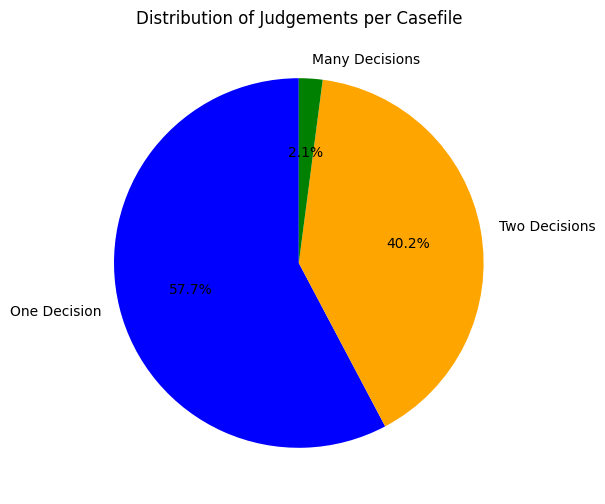

In [13]:
# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Judgements per Casefile')

plt.show()

### Work with only procedures that ended witht judgements, and not by orders. 

We could have two scenarios. 

The first one is to have a procedure that have two decisions. One from the lower court, and other from the higher one. 

The second one is to have a procedure that only have a single judgement, and was no appelation. 

We need to create one group with casefiles that contains 1st instance and 2nd instance decisions

In [6]:
judgements_2 = filter_vista_cases(judgements_df)

In [225]:
unique_count = judgements_2['expediente_n°_'].nunique()

print("Number of unique values in 'expediente_n°_':", unique_count)

Number of unique values in 'expediente_n°_': 8281


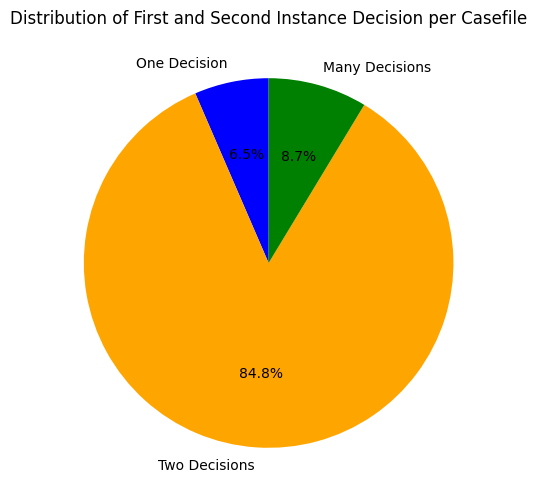

In [14]:
# I expect that, at least, I must have two decisions. First instance decision with its Seccond instance decision. 

expediente_counts = judgements_2['expediente_n°_'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of First and Second Instance Decision per Casefile')

plt.show()

In [219]:
judgements_counts = judgements_2['acto_'].value_counts()
judgements_counts

sentencia de vista                                        7995
sentencia                                                 7428
sentencia de vista que confirma (a ejecucion)              311
sentencia fundada                                          307
sentencia fundada en parte                                 250
sentencia infundada                                        218
auto q declara consentida la sentencia                     133
puesta a despacho para sentencia                           121
auto que declara consentida la sentencia/auto de vista      52
sentencia de vista que confirma (a archivo)                 51
sentencia de vista que anula (a tramite)                    47
sentencia de vista que revoca (a ejecucion)                 30
sentencia improcedente                                      19
sentencia de vista que revoca (a archivo)                   15
auto que declara consentida sentencia                        8
sentencia fundada la demanda                           

In [9]:
expediente_counts = judgements_2['expediente_n°_'].value_counts()
expediente_counts

00442-2018-0-2802-JP-LA-03    7
01392-2018-0-1408-JR-FC-02    6
00547-2018-0-2801-JR-LA-01    6
00228-2018-0-1706-JR-LA-01    6
00160-2018-0-3102-JP-LA-01    6
                             ..
00036-2018-0-1601-SP-LA-02    1
00035-2018-0-1601-SP-LA-01    1
00587-2018-0-2001-JP-FC-01    1
00021-2018-0-1601-SP-LA-02    1
00246-2018-0-1608-JP-FC-01    1
Name: expediente_n°_, Length: 8281, dtype: int64

We have 8,281 cases files that contains first and second instance decisions. 
We have a good sign, since most of our case files only contains two decisions, which means we have a first instance decision, and its correspondent second instance. 
We must remember, by convention, we assign the term 'vista' to the judicial decisions that are solving an appelation. 

In [291]:
condition_acto = judgements_2['acto_'].str.contains('vista', case=False, na=False)
judgements_2_v = judgements_2[condition_acto]

In [221]:
expediente_counts = judgements_2_v['expediente_n°_'].value_counts()
expediente_counts

01392-2018-0-1408-JR-FC-02    3
00442-2018-0-2802-JP-LA-03    3
00160-2018-0-3102-JP-LA-01    3
00547-2018-0-2801-JR-LA-01    3
00305-2018-0-2802-JR-LA-01    3
                             ..
00100-2018-0-1411-JR-CI-01    1
00099-2018-0-1411-JR-CI-01    1
00097-2018-0-1401-JR-CI-01    1
00094-2018-0-1401-JR-CI-01    1
00246-2018-0-1608-JP-FC-01    1
Name: expediente_n°_, Length: 8281, dtype: int64

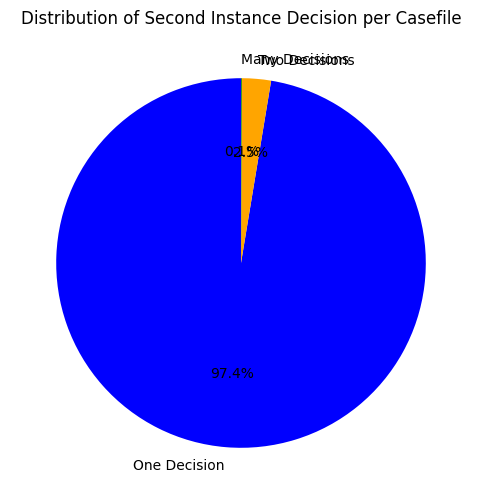

In [227]:
# I expect that, at least, I must have two decisions. First instance decision with its Seccond instance decision. 

expediente_counts = judgements_2_v['expediente_n°_'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Second Instance Decision per Casefile')

plt.show()

In [292]:
# Define patterns
patterns = [
    r'R\s*E\s*S\s*U\s*E\s*L\s*V\s*E\s*:\s*',
    r'D\s*E\s*C\s*I\s*S\s*I\s*Ó\s*N\s*:\s*',
    r'D\s*E\s*C\s*I\s*D\s*E\s*:\s*',
    r'P\s*A\s*R\s*T\s*E\s*\s*R\s*E\s*S\s*O\s*L\s*U\s*T\s*I\s*V\s*A\s*',
    r'D\s*E\s*C\s*L\s*A\s*R\s*A\s*:\s*',
    r'D\s*E\s*C\s*I\s*S\s*I\s*O\s*N\s*:\s*',
    r'R\s*E\s*S\s*U\s*E\s*L\s*V\s*O\s*:\s*',
    r'D\s*I\s*S\s*P\s*O\s*N\s*G\s*O\s*:\s*',
    r'F\s*A\s*L\s*L\s*O\s*:\s*',
    r'L\s*E\s*Y\s*\s*2\s*8\s*2\s*3\s*7\s*',
    r'R\s*E\s*S\s*O\s*L\s*V\s*E\s*M\s*O\s*S\s*:\s*',
    r'D\s*E\s*C\s*L\s*A\s*R\s*A\s*R\s*O\s*N\s*',
    r'C\s*O\s*N\s*F\s*I\s*R\s*M\s*A\s*R\s*O\s*N\s*:\s*',
    r'S\s*E\s*\s*D\s*E\s*C\s*L\s*A\s*R\s*A\s*',
    r'D\s*E\s*C\s*L\s*A\s*R\s*A\s*R\s*:\s*',
    r'D\s*E\s*C\s*I\s*S\s*I\s*Ó\s*N\s*',
    r'R\s*E\s*S\s*O\s*L\s*V\s*I\s*E\s*R\s*O\s*N\s*:\s*',
    r'C\s*A\s*U\s*S\s*A\s*:\s*',
    r'C\s*O\s*N\s*S\s*I\s*D\s*E\s*R\s*A\s*C\s*I\s*O\s*N\s*E\s*S\s*',
    r'F\s*U\s*N\s*D\s*A\s*M\s*E\s*N\s*T\s*O\s*S\s*\s*P\s*O\s*R\s*\s*L\s*O\s*S\s*\s*Q\s*U\s*E\s*',
    r'D\s*E\s*C\s*I\s*S\s*I\s*O\s*N\s*',
    r'C\s*O\s*N\s*S\s*I\s*D\s*E\s*R\s*A\s*C\s*I\s*O\s*N\s*E\s*S\s*E\s*X\s*P\s*U\s*E\s*S\s*T\s*A\s*S\s*',
    r'D\s*I\s*S\s*P\s*O\s*N\s*E\s*:\s*',
    r'P\s*O\s*R\s*\s*L\s*O\s*S\s*\s*F\s*U\s*N\s*D\s*A\s*M\s*E\s*N\s*T\s*O\s*'

]


In [293]:
# Extract text using regex
def extract_text(row):
    text = str(row['text'])  # Convert to string

    for pattern in patterns:
        match = re.search(pattern, text, flags=re.IGNORECASE)
        if match:
            start_index = match.end()
            return row['text'][start_index:]

    return None


In [294]:
# Apply the function to create a new column with the extracted text
judgements_2_v['text'] = judgements_2_v['text'].fillna('')
judgements_2_v['resolutive_section'] = judgements_2_v.apply(extract_text, axis=1)

C:\Users\PC\AppData\Local\Temp\ipykernel_30256\761926054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements_2_v['text'] = judgements_2_v['text'].fillna('')
C:\Users\PC\AppData\Local\Temp\ipykernel_30256\761926054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements_2_v['resolutive_section'] = judgements_2_v.apply(extract_text, axis=1)


In [295]:
def contains_keywords(text, keywords):
    if text is None:
        return False
    text_lower = text.lower()
    return any(keyword.lower() in text_lower for keyword in keywords)


In [310]:
# First set of keywords
keywords_confirm = ['CONFIRMAR', 'consentid','CONFIRM','CONFIRMARON']

# Second set of keywords
keywords_reverse = ['REVOCAR', 'nul', 'infund', 'improcedente', 'REVOCARON','REVOC']

# Apply the function to create the 'Confirm' column
judgements_2_v['Confirm'] = judgements_2_v['resolutive_section'].apply(contains_keywords, args=(keywords_confirm,))

# Apply the function to create the 'Reverse' column conditionally
judgements_2_v['Reverse'] = judgements_2_v.apply(
    lambda row: contains_keywords(row['resolutive_section'], keywords_reverse) if not row['Confirm'] else False, axis=1
)


C:\Users\PC\AppData\Local\Temp\ipykernel_30256\647036596.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements_2_v['Confirm'] = judgements_2_v['resolutive_section'].apply(contains_keywords, args=(keywords_confirm,))
C:\Users\PC\AppData\Local\Temp\ipykernel_30256\647036596.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements_2_v['Reverse'] = judgements_2_v.apply(


In [276]:
def contains_keywords(text, keywords):
    if text is None:
        return False
    return any(keyword in text for keyword in keywords)

In [301]:
keywords = ['CONFIRMAR', 'consentid']

# Apply the function to create the new column
judgements_2_v['Confirm'] = judgements_2_v['resolutive_section'].apply(contains_keywords, args=(keywords,))
judgements_2_v

C:\Users\PC\AppData\Local\Temp\ipykernel_30256\3675844961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements_2_v['Confirm'] = judgements_2_v['resolutive_section'].apply(contains_keywords, args=(keywords,))


,Unnamed: 0,expediente_n°_,organo_jurisdiccional_,distrito_judicial_,juez,especialista_legal_,fecha_de_inicio_,proceso_,observacion_,especialidad_,...,descargado,num,text_processed,error,file_path,parte_resolutiva,text,resolutive_section,Confirm,Reverse
16,19,00001-2018-0-0201-JP-CI-02,2° JUZGADO PAZ LETRADO - Sede Central,ANCASH,SANTISTEBAN VALENZUELA AILLENY ADELA,AGUILAR ESPINOZA DAVID ALFREDO,05/01/2018,SUMARISIMO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,1.0,5.0,corte superior justicia ancash primer juzgado ...,NaN,data/2018/downloaded_files/00001-2018-0-0201-J...,falla declarando infundada la demanda interpue...,Corte Superior de Justicia de Ancash \n\nPRIME...,"""FALLA: declarando INFUNDADA la demanda interp...",False,True
494,515,00002-2018-0-0201-JP-FC-02,2° JUZGADO PAZ LETRADO - Sede Central,ANCASH,SANTISTEBAN VALENZUELA AILLENY ADELA,"ARRIVASPLATA LOLI, DINA IRMA",04/01/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,1.0,23.0,juzgado familia sede central expediente materi...,NaN,data/2018/downloaded_files/00002-2018-0-0201-J...,confirmar la sentencia venida grado declara fu...,1° JUZGADO FAMILIA - Sede Central \nEXPEDIENTE...,"CONFIRMAR la sentencia \nvenida en grado, que...",True,False
901,943,00010-2018-0-0212-JP-FC-01,JUZGADO DE PAZ LETRADO - Sede Sihuas,ANCASH,MENDOZA ASENCIOS WILBER,VALVERDE MARRUFO YAQUELIN LORENA,05/03/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,1.0,3.0,juzgado mixto sede sihuas expediente materia j...,NaN,data/2018/downloaded_files/00010-2018-0-0212-J...,declarar fundada parte la demanda interpuesta ...,JUZGADO MIXTO - Sede Sihuas \nEXPEDIENTE \n \n...,"CONFIRMAR la sentencia apelada, signada c...",True,False
1123,1169,00015-2018-0-0201-JP-FC-02,2° JUZGADO PAZ LETRADO - Sede Central,ANCASH,SANTISTEBAN VALENZUELA AILLENY ADELA,RODRIGUEZ TAHUA MARTHA MARIA,09/01/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,1.0,10.0,juzgado familia sede central expediente materi...,NaN,data/2018/downloaded_files/00015-2018-0-0201-J...,NaN,2° JUZGADO FAMILIA - Sede Central \nEXPEDIENTE...,inclusive ordena inmediatamente para que se de...,False,True
1623,1691,00028-2018-0-0201-JP-FC-01,3°JUZGADO DE PAZ LETRADO - Sede Central,ANCASH,HUERTA BOJORQUEZ CARMEN EUGENIA,"QUITO ROJAS, JESSICA DEL CARMEN",12/01/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,1.0,2.0,juzgado familia sede central expediente materi...,NaN,data/2018/downloaded_files/00028-2018-0-0201-J...,hacer efectivo apercibimiento decretado la res...,2° JUZGADO FAMILIA - Sede Central \nEXPEDIENTE...,“1) HACER EFECTIVO EL \nAPERCIBIMIENTO dec...,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523852,1671615,00071-2018-0-3301-JR-CI-01,3° JUZGADO CIVIL - SEDE ANEXO 2,PUENTE PIEDRA - VENTANILLA,ESTELA SOLANO ALEJOS,"LARA VERASTEGUI, DENNIS SMITH",25/06/2018,ESPECIAL,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,1.0,9.0,expediente materia demandante demandado juzgad...,NaN,data/2018/downloaded_files/00071-2018-0-3301-J...,reconocer adeudo devengado la municipalidad di...,\n\n \n\n \nEXPEDIENTE N° \nMATERIA \n \nDEMA...,"1) CONFIRMAR EN PARTE LA SENTENCIA, contenid...",True,False
1524789,1672664,00108-2018-0-3301-JR-CI-02,2° JUZGADO CIVIL - SEDE ANEXO 2,PUENTE PIEDRA - VENTANILLA,OTÁROLA PAREDES MARÍA NATIVIDAD,AGUSTIN REYES OBREGON,24/04/2018,ABREVIADO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,1.0,9.0,corte superior justicia ventanilla sala superi...,NaN,data/2018/downloaded_files/00108-2018-0-3301-J...,confirmar extremo condena pago costas costos p...,\n\nCORTE SUPERIOR DE JUSTICIA DE VENTANILLA ...,1) CONFIRMAR la SENTENCIA emitida mediante res...,True,False
1525785,1673761,00150-2018-0-3301-JR-CI-02,2° JUZGADO CIVIL - SEDE ANEXO 2,PUENTE PIEDRA - VENTANILLA,OTÁROLA PAREDES MARÍA NATIVIDAD,AGUSTIN REYES OBREGON,05/06/2018,SUMARIS

In [315]:
judge_counts = judgements_2_v.groupby('juez').agg({
    'Confirm': 'sum',
    'Reverse': 'sum'
}).reset_index()

# Rename columns for clarity
judge_counts.columns = ['Judge', 'Confirm_Count', 'Reverse_Count']
judge_counts

,Judge,Confirm_Count,Reverse_Count
0,<NO DEFINIDO>,51,10
1,ABASALO SANDOVAL PAOLA MICHELLE,7,0
2,ABSI LUQUE NEYSME GRACIELA MERCEDES,2,0
3,ACEVEDO DIEZ CECILIA DEL PILAR,52,10
4,ACOSTA MIRAVAL FLOR DE ADA YANETH,5,0
...,...,...,...
669,ZEVALLOS BASUALDO JUAN ANDRES,5,0
670,ZEVALLOS PAREDES GIOVANNA DEL CARMEN,4,2
671,ZUASNABAR MUNARRIZ PEDRO PABLO,7,5
672,ZUMARAN ALFARO DALIA BLANCA,0,0


In [317]:
judge_counts.to_excel(r'D:\Proyectos\amag\classification\confirm_reversal_2018.xlsx')

Working with judgements that were not appealed 

In [321]:
judgements_1 = separate_case_files(judgements_df, judgements_2)

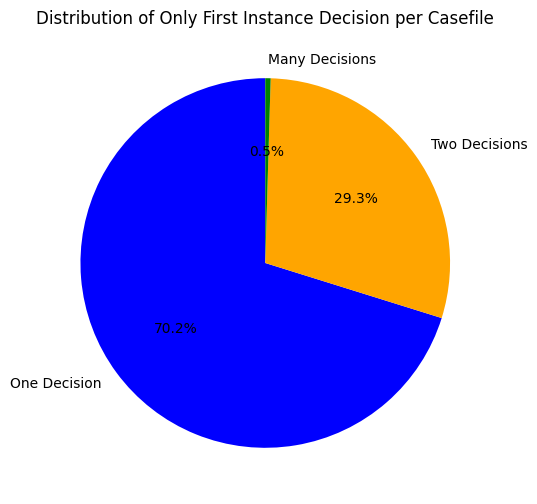

In [322]:
# I expect that I must have most casefiles with one decision. Only the first instance. 

expediente_counts = judgements_1['expediente_n°_'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Only First Instance Decision per Casefile')

plt.show()

In [340]:
# Convert 'date' column to datetime format
judgements_1['date'] = pd.to_datetime(judgements_1['date'])

# Convert 'fecha_de_inicio' column to datetime format
judgements_1['fecha_de_inicio_'] = pd.to_datetime(judgements_1['fecha_de_inicio_'], format='%d/%m/%Y')

# Calculate the difference in days between 'date' and 'fecha_de_inicio' columns
judgements_1['days_difference'] = (judgements_1['date'] - judgements_1['fecha_de_inicio_']).dt.days


            date fecha_de_inicio_  days_difference
4     2019-08-05       2018-03-16              507
9     2021-08-02       2018-11-01             1005
10    2021-08-12       2018-12-04              982
11    2020-10-30       2018-05-01              913
12    2018-04-06       2018-11-01             -209
...          ...              ...              ...
81460 2019-07-09       2018-05-24              411
81481 2019-10-04       2018-12-18              290
81482 2019-09-03       2018-12-18              259
81483 2018-10-25       2018-06-25              122
81484 2018-10-24       2018-04-23              184

[44455 rows x 3 columns]


In [352]:
positive_rows = judgements_1[judgements_1['days_difference'] >= 0]
judgements_counts = positive_rows['acto_'].value_counts()
judgements_counts

sentencia                                                    27462
auto q declara consentida la sentencia                       12235
sentencia fundada                                              564
auto que declara consentida sentencia                          379
sentencia fundada en parte                                     313
sentencia infundada                                            264
puesta a despacho para sentencia                               198
sentencia fundada la demanda                                   197
sentencia improcedente                                          57
audiencia de alegatos y sentencia (impugnación de laudos)       47
resolucion de traigase para sentenciar                          24
pedido de sentencia                                             20
auto que declara consentida la sentencia                        19
ejecucion de sentencia                                          17
sentencia infundada la demanda                                

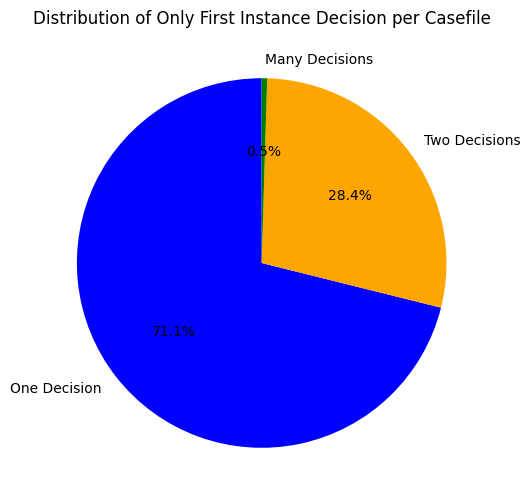

In [353]:
expediente_counts = positive_rows['expediente_n°_'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Only First Instance Decision per Casefile')

plt.show()

## Second Step of the Filter

We will assume that the case files above were solved (we have, at least, 42, 385). We will do the following:

1. Remove the closed case files from the sentencias_df.
2. Keep only the rows that contains the word 'auto' in the column 'acto_'. As it was explained before, if there is no judgement, a procedure could be ended by an 'auto'.
3. We will create two datasets, the first one with lower and higher court decisions, and the other one with only the lower court decision. 

In [ ]:
orders_df = separate_case_files(documents_amag, judgements_df)

# Create a boolean mask to identify rows containing the word 'auto' (case-insensitive)
mask = orders_df['acto_'].str.contains('auto', case=False, na=False)

# Filter the DataFrame to keep only rows where 'acto_' contains 'auto'
orders_df = orders_df[mask]

There are two ways an order could end a procedure. The first one if the parties, or one of them, request it. The second one is if a judge decides it. 

In [ ]:
# Let's start with casefiles that ended by action of the parties

keywords = ['desistimiento', 'conciliacion total', 'allanamiento', 'transacción']

orders_0 = filter_keywords_cases(orders_df, keywords)

orders_0

,Unnamed: 0,expediente_n°_,organo_jurisdiccional_,distrito_judicial_,juez,especialista_legal_,fecha_de_inicio_,proceso_,observacion_,especialidad_,...,revoca2,nula2,confirma2,fundada,fundada_parte,infundada,vista,revoca,nula,confirma
3929,3687,00069-2018-0-0201-JP-FC-01,1° JUZGADO PAZ LETRADO - Sede Central,ANCASH,RETUERTO TUEROS BESSI YOHANA,OSORIO FERNANDEZ DEYSI KARIN,25/01/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0
3930,3688,00069-2018-0-0201-JP-FC-01,1° JUZGADO PAZ LETRADO - Sede Central,ANCASH,RETUERTO TUEROS BESSI YOHANA,OSORIO FERNANDEZ DEYSI KARIN,25/01/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0
3931,3689,00069-2018-0-0201-JP-FC-01,1° JUZGADO PAZ LETRADO - Sede Central,ANCASH,RETUERTO TUEROS BESSI YOHANA,OSORIO FERNANDEZ DEYSI KARIN,25/01/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0
3932,3690,00069-2018-0-0201-JP-FC-01,1° JUZGADO PAZ LETRADO - Sede Central,ANCASH,RETUERTO TUEROS BESSI YOHANA,OSORIO FERNANDEZ DEYSI KARIN,25/01/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0
10164,8797,00192-2018-0-0210-JP-FC-01,JUZGADO DE PAZ LETRADO - Sede Pomabamba,ANCASH,ALVAREZ ACERO ROCIO DELSY,CASTILLO PINEDA ROBERT YHOFREY,30/10/2018,ESPECIAL,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972331,1666832,00508-2018-0-3301-JP-FC-04,JUZGADO DE PAZ LETRADO DE ANCÓN Y SANTA ROSA,PUENTE PIEDRA - VENTANILLA,CADILLO MERCADO YNES GLADYS,ANCHO CROCCO MADELEINE KATHERINE,20/12/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0
1974610,1668539,00589-2018-0-3301-JP-FC-02,2º JUZGADO DE PAZ LETRADO DE FAMILIA DE VENTAN...,PUENTE PIEDRA - VENTANILLA,RODRIGUEZ ROSALES CARLOS,MARTHA MAURICIO CAZORLA,03/04/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0
1974611,1668540,00589-2018-0-3301-JP-FC-02,2º JUZGADO DE PAZ LETRADO DE FAMILIA DE VENTAN...,PUENTE PIEDRA - VENTANILLA,RODRIGUEZ ROSALES CARLOS,MARTHA MAURICIO CAZORLA,03/04/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0
1974612,1668541,00589-2018-0-3301-JP-FC-02,2º JUZGADO DE PAZ LETRADO DE FAMILIA DE VENTAN...,PUENTE PIEDRA - VENTANILLA,RODRIGUEZ ROSALES CARLOS,MARTHA MAURICIO CAZORLA,03/04/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA CIVIL,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
expediente_counts = orders_0['expediente_n°_'].value_counts()
expediente_counts

00550-2018-0-2802-JR-LA-01    68
00756-2018-0-1618-JP-FC-01    57
01357-2018-0-1408-JR-FC-01    40
01517-2018-0-1801-JP-FC-07    39
00168-2018-0-1821-JP-FC-01    39
                              ..
00107-2018-0-1101-JP-FC-01     2
00114-2018-0-1101-JP-CI-01     2
00057-2018-0-1714-JP-CI-02     2
00252-2018-0-1703-JP-FC-01     1
00168-2018-0-1104-JP-FC-01     1
Name: expediente_n°_, Length: 534, dtype: int64

Work with orders didn't finish by parties

In [ ]:
orders_judge = pd.merge(orders_df, requested_parties[['expediente_n°_']], on='expediente_n°_', how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
expediente_counts = orders_judge['expediente_n°_'].value_counts()
expediente_counts

00080-2018-0-3301-JR-CI-03    42
00130-2018-0-3301-JR-CI-03    41
00102-2018-0-3301-JR-CI-03    31
00171-2018-0-1401-JR-CI-01    28
00031-2018-0-1408-JR-CI-01    28
                              ..
00076-2018-0-1103-JP-FC-01     1
00266-2018-0-2005-JR-FC-01     1
00266-2018-0-2001-JR-FC-03     1
00265-2018-0-2005-JR-FC-01     1
00192-2018-0-1504-JP-FC-01     1
Name: expediente_n°_, Length: 86748, dtype: int64

In [ ]:
# We will create a new dataset with only the files that contains 'vista' in acto_, which means, the case files that contains a higher court decision

# Create a boolean Series where True indicates that 'acto_' contains 'auto'
contains_vista = orders_judge['acto_'].str.contains('vista', na=False)

# Group by 'expediente_n°_' and check if any 'acto_' in each group contains 'auto'
grouped = orders_judge.groupby('expediente_n°_').apply(lambda x: any(x['acto_'].str.contains('vista', na=False)))

# Create a new DataFrame containing only the 'expediente_n°_' that are associated with at least one 'acto_' containing 'auto'
orders_judge_v = orders_judge[orders_judge['expediente_n°_'].isin(grouped[grouped].index)]
orders_judge_v

,Unnamed: 0,expediente_n°_,organo_jurisdiccional_,distrito_judicial_,juez,especialista_legal_,fecha_de_inicio_,proceso_,observacion_,especialidad_,...,revoca2,nula2,confirma2,fundada,fundada_parte,infundada,vista,revoca,nula,confirma
33,192,00011-2018-0-0212-JP-CI-01,JUZGADO DE PAZ LETRADO - Sede Sihuas,ANCASH,MENDOZA ASENCIOS WILBER,VALVERDE MARRUFO YAQUELIN LORENA,30/01/2018,NO CONTENCIOSO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
34,196,00011-2018-0-0212-JP-CI-01,JUZGADO DE PAZ LETRADO - Sede Sihuas,ANCASH,MENDOZA ASENCIOS WILBER,VALVERDE MARRUFO YAQUELIN LORENA,30/01/2018,NO CONTENCIOSO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
35,199,00011-2018-0-0212-JP-CI-01,JUZGADO DE PAZ LETRADO - Sede Sihuas,ANCASH,MENDOZA ASENCIOS WILBER,VALVERDE MARRUFO YAQUELIN LORENA,30/01/2018,NO CONTENCIOSO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
36,202,00011-2018-0-0212-JP-CI-01,JUZGADO DE PAZ LETRADO - Sede Sihuas,ANCASH,MENDOZA ASENCIOS WILBER,VALVERDE MARRUFO YAQUELIN LORENA,30/01/2018,NO CONTENCIOSO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
69,321,00020-2018-0-0201-JP-CI-02,2° JUZGADO PAZ LETRADO - Sede Central,ANCASH,SANTISTEBAN VALENZUELA AILLENY ADELA,"ARRIVASPLATA LOLI, DINA IRMA",15/01/2018,UNICO DE EJECUCION,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228862,1677889,00535-2018-2-3301-JR-FT-01,3° JUZGADO DE FAMILIA DE VENTANILLA Y MI PERÚ,PUENTE PIEDRA - VENTANILLA,YOLANDA PETRONILA CAMPOS SOTELO,"DUVEL RENE CANCHAPOMA AQUINO,",29/03/2019,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA TUTELAR,...,0,0,0,0,0,0,1,0,1,0
228982,1678482,00633-2018-2-3301-JR-FT-01,JUZGADO CIVIL - SEDE ANCON,PUENTE PIEDRA - VENTANILLA,<NO DEFINIDO>,CAJAS PEREZ JUAN DIEGO,29/01/2019,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA TUTELAR,...,0,0,0,0,0,0,1,0,0,1
229026,1678688,00668-2018-2-3301-JR-FT-01,JUZGADO DE FAMILIA DE ANCÓN Y SANTA ROSA,PUENTE PIEDRA - VENTANILLA,VITERI VALIENTE YESSICA PAOLA,"BRINGAS ENCISO, JUANA",29/01/2019,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA TUTELAR,...,0,0,0,0,0,0,0,0,0,0
229027,1678698,00668-2018-2-3301-JR-FT-01,JUZGADO DE FAMILIA DE ANCÓN Y SANTA ROSA,PUENTE PIEDRA - VENTANILLA,VITERI VALIENTE YESSICA PAOLA,"BRINGAS ENCISO, JUANA",29/01/2019,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA TUTELAR,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
expediente_counts = orders_judge_v['expediente_n°_'].value_counts()
expediente_counts

00106-2018-0-1101-JR-CI-01     25
00071-2018-0-1401-JR-CI-01     23
00020-2018-0-2802-JM-CI-01     22
00213-2018-0-1401-JP-CI-03     20
00065-2018-0-2802-JM-CI-01     20
                               ..
00030-2018-55-1601-JR-CI-05     1
01080-2018-61-1601-JP-FC-03     1
00919-2018-16-1601-JP-FC-03     1
00640-2018-9-1601-JP-FC-03      1
00672-2018-1-3301-JR-FT-01      1
Name: expediente_n°_, Length: 2559, dtype: int64

Let's work with cases files that does not contain a higher court decision

In [ ]:
orders_judge_n = pd.merge(orders_judge, orders_judge_v[['expediente_n°_']], on='expediente_n°_', how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
expediente_counts = orders_judge_n['expediente_n°_'].value_counts()
expediente_counts

00080-2018-0-3301-JR-CI-03     42
00130-2018-0-3301-JR-CI-03     41
00102-2018-0-3301-JR-CI-03     31
00171-2018-0-1401-JR-CI-01     28
00031-2018-0-1408-JR-CI-01     28
                               ..
00146-2018-47-1618-JP-FC-01     1
00147-2018-0-1605-JP-FC-01      1
00147-2018-0-1608-JP-FC-01      1
00365-2018-0-2802-JM-CI-01      1
00544-2018-3-1824-JP-FC-02      1
Name: expediente_n°_, Length: 84189, dtype: int64

In [ ]:
keywords = ['archivo definitivo', 'inadmisible', 'auto final', 'improcedente', 
            'auto que rechaza la demanda', 'abandono']

# Use str.contains with the regex pattern
orders_finished = orders_judge_n['acto_'].str.contains('|'.join(keywords), na=False)

# Group by 'expediente_n°_' and check if any 'acto_' in each group contains 'auto'
grouped = orders_judge_n.groupby('expediente_n°_').apply(lambda x: any(x['acto_'].str.contains('|'.join(keywords), na=False)))

# Create a new DataFrame containing only the 'expediente_n°_' that are associated with at least one 'acto_' containing 'keywords'
orders_finished = orders_judge_n[orders_judge_n['expediente_n°_'].isin(grouped[grouped].index)]
orders_finished

,Unnamed: 0,expediente_n°_,organo_jurisdiccional_,distrito_judicial_,juez,especialista_legal_,fecha_de_inicio_,proceso_,observacion_,especialidad_,...,revoca2,nula2,confirma2,fundada,fundada_parte,infundada,vista,revoca,nula,confirma
0,33,00002-2018-0-0201-JP-CI-01,1° JUZGADO PAZ LETRADO - Sede Central,ANCASH,RETUERTO TUEROS BESSI YOHANA,OSORIO FERNANDEZ DEYSI KARIN,08/01/2018,UNICO DE EJECUCION,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
1,34,00002-2018-0-0201-JP-CI-01,1° JUZGADO PAZ LETRADO - Sede Central,ANCASH,RETUERTO TUEROS BESSI YOHANA,OSORIO FERNANDEZ DEYSI KARIN,08/01/2018,UNICO DE EJECUCION,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
2,35,00002-2018-0-0201-JP-CI-01,1° JUZGADO PAZ LETRADO - Sede Central,ANCASH,RETUERTO TUEROS BESSI YOHANA,OSORIO FERNANDEZ DEYSI KARIN,08/01/2018,UNICO DE EJECUCION,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
4,38,00003-2018-0-0201-JP-CI-02,2° JUZGADO PAZ LETRADO - Sede Central,ANCASH,SANTISTEBAN VALENZUELA AILLENY ADELA,AGUILAR ESPINOZA DAVID ALFREDO,09/01/2018,UNICO DE EJECUCION,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,1,0,0,0,0,0,0
5,42,00003-2018-0-0201-JP-CI-02,2° JUZGADO PAZ LETRADO - Sede Central,ANCASH,SANTISTEBAN VALENZUELA AILLENY ADELA,AGUILAR ESPINOZA DAVID ALFREDO,09/01/2018,UNICO DE EJECUCION,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,CIVIL,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278193,1678713,00670-2018-0-3301-JR-FT-01,JUZGADO CIVIL - SEDE ANCON,PUENTE PIEDRA - VENTANILLA,<NO DEFINIDO>,CAJAS PEREZ JUAN DIEGO,06/08/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA TUTELAR,...,0,0,0,0,0,0,0,0,0,0
278194,1678725,00671-2018-0-3301-JR-FT-01,JUZGADO CIVIL - SEDE ANCON,PUENTE PIEDRA - VENTANILLA,<NO DEFINIDO>,CAJAS PEREZ JUAN DIEGO,06/08/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA TUTELAR,...,0,0,0,0,0,0,0,0,0,0
278196,1678739,00672-2018-0-3301-JR-FT-01,1° JUZGADO DE FAMILIA DE VENTANILLA Y MI PERÚ,PUENTE PIEDRA - VENTANILLA,KATHERINE LA ROSA CASTILLO,MEZZICH HOLGUIN JONATHAN ROCCO,20/04/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA TUTELAR,...,0,0,0,0,0,0,0,0,0,0
278198,1678762,00673-2018-0-3301-JR-FT-01,JUZGADO CIVIL - SEDE ANCON,PUENTE PIEDRA - VENTANILLA,<NO DEFINIDO>,CAJAS PEREZ JUAN DIEGO,06/08/2018,UNICO,\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t...,FAMILIA TUTELAR,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
expediente_counts = orders_finished['expediente_n°_'].value_counts()
expediente_counts

00080-2018-0-3301-JR-CI-03     42
00130-2018-0-3301-JR-CI-03     41
00102-2018-0-3301-JR-CI-03     31
00171-2018-0-1401-JR-CI-01     28
00100-2018-0-3301-JR-CI-03     25
                               ..
00046-2018-0-1301-JR-CI-01      1
00046-2018-1-1308-JR-CI-03      1
00057-2018-13-1308-JR-CI-03     1
00605-2018-0-2009-JM-FC-01      1
00675-2018-0-3301-JR-FT-01      1
Name: expediente_n°_, Length: 53403, dtype: int64

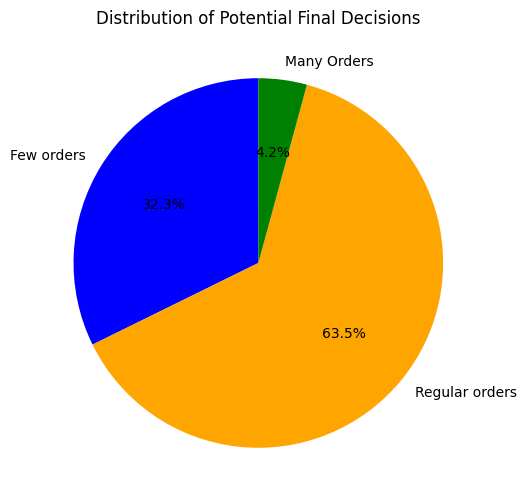

In [ ]:
# Let's count how many case files we have
orders_counts = auto_df['expediente_n°_'].value_counts()
orders_counts

# Create three subsets based on the specified criteria
single_observation = orders_counts[(orders_counts >= 0) & (orders_counts <= 2)]
second_observations = orders_counts[(orders_counts >= 2) & (orders_counts <= 10)]
third_observations = orders_counts[orders_counts >= 10]

total_count = len(orders_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

# This classification as 'few', 'regular' and 'many' was made by me with no official source, more than my understanding. 

labels = ['Few orders', 'Regular orders', 'Many Orders']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Potential Final Decisions')

plt.show()

In [ ]:
orders_counts = auto_df['acto_'].value_counts()
orders_counts

auto                                            3941
auto vista                                      2414
auto admisorio                                   718
auto final                                       616
auto improcedente                                592
                                                ... 
auto saneamiento remision ministerio publico       1
auto declara fundada excepcion caducidad           1
auto denegatorio                                   1
auto inadmisible apelacion                         1
apelacion auto                                     1
Name: acto_, Length: 70, dtype: int64

In [ ]:
orders_counts_str = orders_counts.to_string()

# Define the path to the output text file
output_file_path = r'D:\Proyectos\amag\orders_counts.txt'

# Write the string to a text file
with open(output_file_path, 'w') as file:
    file.write(orders_counts_str)

In [ ]:
column_names = orders_df.columns

# Print the column names
print(column_names)

Index(['expediente_n°_', 'organo_jurisdiccional_', 'distrito_judicial_',
       'juez', 'especialista_legal_', 'fecha_de_inicio_', 'proceso_',
       'observacion_', 'especialidad_', 'materia_s_', 'estado_',
       'etapa_procesal_', 'fecha_conclusion_', 'ubicacion_',
       'motivo_conclusion_', 'sumilla_', 'juez_splitted', 'n_judges_case',
       'link', 'date', 'resolucion_', 'tipo_de_notificacion_', 'acto_',
       'fojas_folios_', 'proveido_', 'descripcion_de_usuario_', 'descargado',
       'num', 'text', 'error', 'file_path'],
      dtype='object')


In [ ]:
# Let's run the third step of the algorithm 

# Function to determine decision based on the third half of the text
def determine_decision(text):
   if pd.isna(text):  # Check if the text is NaN
        return 'No Text'
   
   len_text = len(str(text))
   third_last_part_start = 2 * len_text // 3
   third_last_part = str(text)[third_last_part_start:]
   
   if any(keyword.lower() in third_last_part.lower() for keyword in keywords):
        return 'Possible F_Decision'
   
   else:
        return 'Pre-step Decision'

keywords = ['se resuelve:', 'decide:', 'falla:', 'fallo:',
            'archivar el presente proceso', 'rechazándose la demanda', 
            'archívese', 'archivese', 'reformandola', 'fundada en parte la demanda', 'infundada la demanda', 
            'fundada la demanda', 'improcedente la demanda']

prueba_df['Decision'] = prueba_df['text'].apply(determine_decision)


In [ ]:
decisions_counts = prueba_df['Decision'].value_counts()
decisions_counts

Pre-step Decision      162173
Possible F_Decision     99903
No Text                  1966
Name: Decision, dtype: int64